In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import backtrader as bt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pyfolio as pf
import quantstats
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
import sys
from scipy.stats import rankdata
from scipy.stats import stats
from scipy.optimize import minimize

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


위험 균형(Risk Parity) 전략을 목표 변동성(Target Volatility)을 맞추어 같이 사용할 수도 있습니다. 이럴 경우, 변동성이 매우 낮은 시장 상황이면 레버리지를 사용해 목표 변동성을 맞출 것이고, 변동성이 크다면 비중을 1보다 낮게 가져가 현금을 보유하도록 할 수 있습니다. 여기서는 포트폴리오 목표 변동성을 10%로 하고, 9.5% ~ 10.5% 사이에 들어오도록 맞추어 보겠습니다. 데이터는 간단하게 2006년 8월부터의 미국 주식, 미국 장기 국채, 미국 부동산, 금, 원자재 데이터를 사용합니다. 미국 단기 국채는 현금 대용입니다. 함수에는 자산 최대 보유 비중과 최소 보유 비중을 입력하도록 구현합니다.

In [2]:
start = '2006-08-01'
end = '2021-02-17'

vti = web.DataReader("VTI", 'yahoo', start, end)['Adj Close'].to_frame("vti")
tlt = web.DataReader("TLT", 'yahoo', start, end)['Adj Close'].to_frame("tlt")
vnq = web.DataReader("VNQ", 'yahoo', start, end)['Adj Close'].to_frame("vnq")
iau = web.DataReader("IAU", 'yahoo', start, end)['Adj Close'].to_frame("iau")
gsg = web.DataReader("GSG", 'yahoo', start, end)['Adj Close'].to_frame("gsg")
shy = web.DataReader("SHY", 'yahoo', start, end)['Adj Close'].to_frame("shy")

가격 데이터로 수익률 데이터를 만듭니다.

In [3]:
price_df = pd.concat([vti, tlt, vnq, iau, gsg], axis=1)
return_df = price_df.pct_change().dropna(axis=0)

cash_return_df = shy.pct_change().dropna(axis=0)

In [4]:
return_df.head()

,vti,tlt,vnq,iau,gsg
Date,,,,,
2006-08-01,-0.005152,-0.000093,-0.005227,0.018653,0.000000
2006-08-02,0.006294,0.003745,-0.001897,0.004500,0.016552
2006-08-03,0.002217,0.000234,0.009504,-0.008960,-0.015895
2006-08-04,-0.000474,0.006059,0.015788,0.003274,-0.003348
2006-08-07,-0.003320,0.000580,-0.009839,0.004195,0.014427


In [5]:
cash_return_df.head()

,shy
Date,
2006-08-01,0.000615
2006-08-02,0.000000
2006-08-03,-0.000126
2006-08-04,0.000879
2006-08-07,0.000376


In [6]:
def RiskParityTargetVol(rets, target, lb, ub) :

    covmat = pd.DataFrame.cov(rets)

    # 목적함수
    def RiskParityObjective(x) :
            
            variance = x.T @ covmat @ x
            sigma = variance ** 0.5
            mrc = 1/sigma * (covmat @ x)
            rc = x * mrc
            a = np.reshape(rc.to_numpy(), (len(rc), 1))
            risk_diffs = a - a.T
            sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
            return (sum_risk_diffs_squared)
    
    # 제약조건: 연간 변동성이 target vol의 95% 이상일 것
    def TargetVolLowerBound(x) :
        
        variance = x.T @ covmat @ x
        sigma = variance ** 0.5 
        sigma_scale = sigma * np.sqrt(252) 
        
        vol_diffs = sigma_scale - (target * 0.95)
        return(vol_diffs)  

    # 제약조건: 연간 변동성이 target vol의 105% 이하일 것
    def TargetVolUpperBound(x) :
        
        variance = x.T @ covmat @ x
        sigma = variance ** 0.5 
        sigma_scale = sigma * np.sqrt(252) 
        
        vol_diffs = (target * 1.05) - sigma_scale
        return(vol_diffs)      
    
    x0 = np.repeat(1/covmat.shape[1], covmat.shape[1]) 
    lbound  = np.repeat(lb, covmat.shape[1])
    ubound  = np.repeat(ub, covmat.shape[1])
    bnds = tuple(zip(lbound, ubound))
    constraints = ({'type': 'ineq', 'fun': TargetVolLowerBound},
                   {'type': 'ineq', 'fun': TargetVolUpperBound})
    options = {'ftol': 1e-20, 'maxiter': 2000}
    
    result = minimize(fun = RiskParityObjective,
                      x0 = x0,
                      method = 'SLSQP',
                      constraints = constraints,
                      options = options,
                      bounds = bnds)
    return(result.x)

위 함수는 목표 변동성 없이 구하는 위험 균형 함수와 비슷합니다. 그러나, 비중 합이 1이고 각 자산 비중이 0 이상이라는 제약 조건이 없으므로, 레버리지도 사용 가능합니다. 레버리지 사용 시 1을 초과하는 비중은 현금을 공매도한 것처럼 구현할 것입니다. 비중 합이 1보다 작은 경우 현금 보유를 해야 합니다. 편의상 현금 차입 비용은 미국 단기 국채로 대체할 것입니다.

자산 비중을 구하기 위한 rolling period는 자유롭게 변경 가능하지만, 편의상 62거래일(3개월)로 가정합니다. 

In [7]:
# 62 days(3 months) 기준으로 rolling 
weight_df = pd.DataFrame(columns=['vti','tlt','vnq','iau','gsg'])

for i in range(len(return_df)-62):
    
    #print(i)
    
    # 63일 분량 데이터 잘라오기 (for문 돌 때마다 index 0~62, 1~63, 2~64, ...)
    temp_return_df = return_df.iloc[i:(i+63), :]
    
    # 63일 중 62일치를 계산에 사용하고 63번째 행은 날짜를 추출
    date_index = str(temp_return_df.iloc[62, :].name)[0:10]
    # Target vol 10% (0.1), 최소/최대 보유 비중은 0과 10 (Long Only, 10배 레버리지까지 허용)
    temp = pd.DataFrame(RiskParityTargetVol(temp_return_df.iloc[0:62, :], 0.1, 0, 10), index=['vti','tlt','vnq','iau','gsg'], columns=[date_index]).T
    
    weight_df = pd.concat([weight_df, temp])

weight_df

,vti,tlt,vnq,iau,gsg
2006-10-27,0.413221,0.527940,0.302153,0.153358,0.169821
2006-10-30,0.409326,0.533432,0.300766,0.152633,0.170118
2006-10-31,0.418298,0.541906,0.296680,0.153394,0.174055
2006-11-01,0.421640,0.530998,0.295829,0.153031,0.173789
2006-11-02,0.413874,0.543401,0.309566,0.153934,0.173866
...,...,...,...,...,...
2021-02-10,0.254544,0.490331,0.186215,0.250904,0.270392
2021-02-11,0.246708,0.475986,0.186944,0.248381,0.277949
2021-02-12,0.247636,0.471855,0.187268,0.244411,0.274675
2021-02-16,0.246802,0.472521,0.186085,0.244851,0.275836


In [8]:
weight_df_final = weight_df

자산군 비중을 다 구했고, 현금 비중을 계산합니다. 현금은 각 자산군 비중 합계가 1보다 클 경우 레버리지를 구현하기 위해 차입한 것처럼 될 것이고, 비중 합계가 1보다 작을 경우 비중 총합을 1로 만들기 위하여 들어갈 것입니다.

In [9]:
weight_df_final['shy'] = 1 - weight_df_final.sum(axis = 1)
weight_df_final

,vti,tlt,vnq,iau,gsg,shy
2006-10-27,0.413221,0.527940,0.302153,0.153358,0.169821,-0.566493
2006-10-30,0.409326,0.533432,0.300766,0.152633,0.170118,-0.566276
2006-10-31,0.418298,0.541906,0.296680,0.153394,0.174055,-0.584334
2006-11-01,0.421640,0.530998,0.295829,0.153031,0.173789,-0.575287
2006-11-02,0.413874,0.543401,0.309566,0.153934,0.173866,-0.594641
...,...,...,...,...,...,...
2021-02-10,0.254544,0.490331,0.186215,0.250904,0.270392,-0.452386
2021-02-11,0.246708,0.475986,0.186944,0.248381,0.277949,-0.435967
2021-02-12,0.247636,0.471855,0.187268,0.244411,0.274675,-0.425845
2021-02-16,0.246802,0.472521,0.186085,0.244851,0.275836,-0.426095


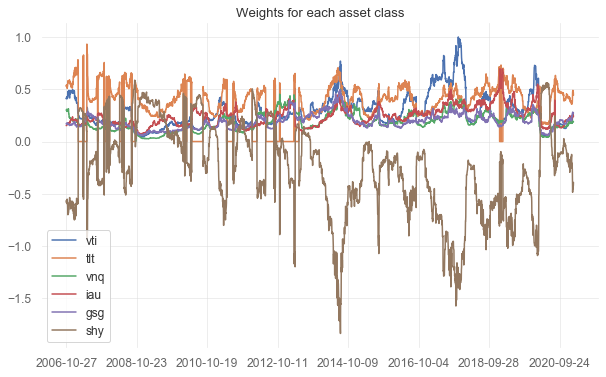

In [10]:
weight_df_final.plot(title = 'Weights for each asset class')

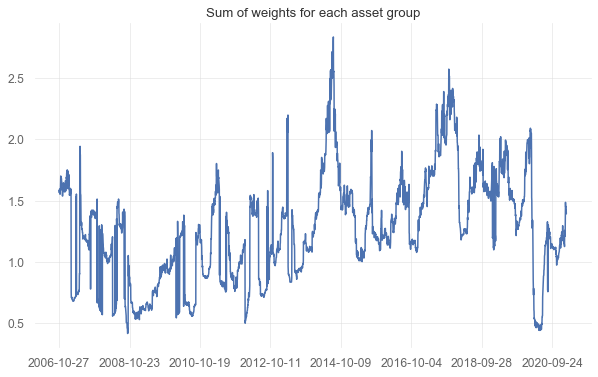

In [11]:
sum_of_asset_weight = 1 - weight_df_final['shy']
sum_of_asset_weight.plot(title = 'Sum of weights for each asset group')

시장 충격이 있어서 변동성이 큰 시기에 시장 노출을 줄이고, 현금 비중을 크게 가져가는 것을 볼 수 있습니다.

각 자산군의 가중치에 일간 수익률을 곱하고, 합산해서 risk parity with target volatility 전략의 모델 포트폴리오 수익률을 구합니다.

In [12]:
rp_tvol_return = (weight_df_final['vti'] * return_df.iloc[62:, :]['vti'] + 
                  weight_df_final['tlt'] * return_df.iloc[62:, :]['tlt'] + 
                  weight_df_final['vnq'] * return_df.iloc[62:, :]['vnq'] + 
                  weight_df_final['iau'] * return_df.iloc[62:, :]['iau'] +
                  weight_df_final['gsg'] * return_df.iloc[62:, :]['gsg'] + 
                  weight_df_final['shy'] * cash_return_df.iloc[62:, :]['shy'])
        
rp_tvol_return

2006-10-27   -0.002730
2006-10-30    0.000007
2006-10-31    0.004197
2006-11-01    0.000295
2006-11-02   -0.008212
                ...   
2021-02-10    0.004074
2021-02-11   -0.004086
2021-02-12   -0.000875
2021-02-16   -0.009615
2021-02-17    0.001413
Length: 3600, dtype: float64

In [13]:
rp_tvol_return.index

Index(['2006-10-27', '2006-10-30', '2006-10-31', '2006-11-01', '2006-11-02',
       '2006-11-03', '2006-11-06', '2006-11-07', '2006-11-08', '2006-11-09',
       ...
       '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-08', '2021-02-09',
       '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-16', '2021-02-17'],
      dtype='object', length=3600)

인덱스가 DatetimeIndex 형식이 아니므로 DatetimeIndex 형식으로 변환합니다.

In [14]:
rp_tvol_return.index = pd.to_datetime(rp_tvol_return.index)

In [15]:
rp_tvol_return.index

DatetimeIndex(['2006-10-27', '2006-10-30', '2006-10-31', '2006-11-01',
               '2006-11-02', '2006-11-03', '2006-11-06', '2006-11-07',
               '2006-11-08', '2006-11-09',
               ...
               '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-08',
               '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12',
               '2021-02-16', '2021-02-17'],
              dtype='datetime64[ns]', length=3600, freq=None)

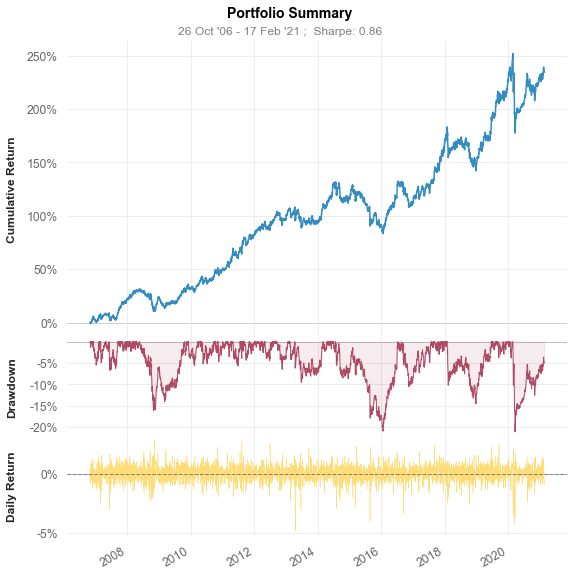

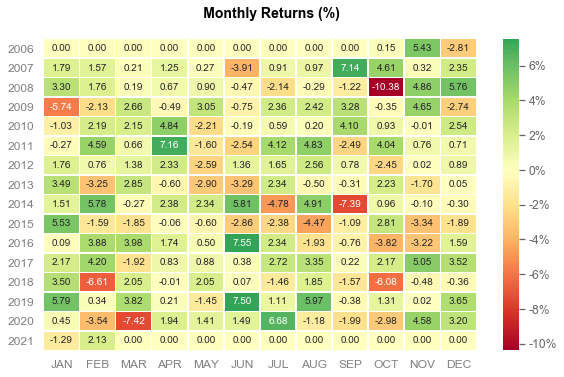

In [16]:
quantstats.reports.plots(rp_tvol_return, mode='basic')

아래 값들은 이 전략의 성과입니다. 구현 목표였던 연간 변동성 10%에 근접하게 나오고 있습니다.

In [17]:
quantstats.reports.metrics(rp_tvol_return, mode='full')

                           Strategy
-------------------------  ----------
Start Period               2006-10-27
End Period                 2021-02-17
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          234.79%
CAGR%                      8.8%
Sharpe                     0.86
Sortino                    1.2
Max Drawdown               -21.14%
Longest DD Days            715
Volatility (ann.)          10.44%
Calmar                     0.42
Skew                       -0.66
Kurtosis                   3.8

Expected Daily %           0.03%
Expected Monthly %         0.7%
Expected Yearly %          7.84%
Kelly Criterion            7.42%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.05%
Expected Shortfall (cVaR)  -1.05%

Payoff Ratio               0.96
Profit Factor              1.16
Common Sense Ratio         1.17
CPC Index                  0.61
Tail Ratio                 1.01
Outlier Win Ratio          3.26
Outlier Loss Ratio         3.47


In [18]:
quantstats.reports.html(rp_tvol_return, output='Report_RPTVOL.html', title='Risk Parity with 10% Target Vol')